## learning-AI101 : diabetes classification
### 당뇨 데이터를 KNN, logistic regression, K-means, decision tree, random forest, SVM 기법을 적용하여 classification

<br>

- **임규연 (lky473736)**
- 2024.07.23. ~ 2024.07.24.에 문서 작성
- **dataset** : https://github.com/plotly/datasets/blob/master/diabetes.csv
- **kaggle** : https://www.kaggle.com/datasets/mathchi/diabetes-data-set/data
- **data abstract** : This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.
- **memo** : 본 데이터는 사실, 예전에 data visualization 및 data science를 처음 연습한 set이다. 본 데이터를 활용하여 Outcome 열에 대한 classification을 진행한 후, Outcome 열을 제거하여 BMI를 label로 regression을 진행하도록 한다. 또한 classification에서, KNN, logistic regression 시 feature selection을 통하여 데이터를 수정 후 각 모델 + random search 후에 score를 파악하여 이전 score와 selection 후 score를 비교하여 보자.

------

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

-------

### 1. 데이터 EDA (탐색적 데이터 분석)

classification을 진행하기 전, 데이터 구조를 파악한다.

- **데이터 구조 파악 및 EDA**
    - 각 feature가 의미하는 바를 분석, 결측치 파악 후 어떻게 classification을 진행하는 것이 탁월할 지 파악
    - 각 feature에 대한 사분위수, mean, max, min, median, corr
    - target의 도수를 bar plot 시각화
    - seaborn을 통한 corr 상관관계 및 histplot 시각화
    - 각 attribute에 대한 box plot 시각화

#### 1-1) 파일 열기, 기초 통계량 분석 및 classifiaction 전략 도출
**./data/diabetes/diabetes.csv**를 열어 본 데이터 파일이 어떤 구성인지, attributes 명과 기초 통계량을 파악 후 classification에 대한 전략을 도출한다.

In [18]:
# 파일 열기

df = pd.read_csv('./data/diabetes/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


header를 확인하니, 본 데이터프레임에서의 각 attribute는 다음과 같은 내용을 의미한다.

- **임신 횟수 (Pregnancies)** : 임신한 횟수
- **포도당 (Glucose)** : 경구 포도당 내성 검사에서 2시간 후의 혈장 포도당 농도
- **혈압 (BloodPressure)** : 이완기 혈압 (mm Hg)
- **피부 두께 (SkinThickness)** : 삼두근 피부 두께 (mm)
- **인슐린 (Insulin)** : 2시간 후의 혈청 인슐린 (mu U/ml)
- **체질량 지수 (BMI)** : 체질량 지수 (몸무게(kg) / (키(m))^2)
- **당뇨병 혈통 함수 (DiabetesPedigreeFunction)** : 당뇨병 혈통 함수
- **나이 (Age)** : 나이 (년)
- **결과 (Outcome)** : 클래스 변수 (0 또는 1)

결국엔 맨 마지막 column인 Outcome 열이 target이 될 것이며, 나머지는 feature가 되어 classification을 진행해야 할 것이다. Outcome 열은 0 혹은 1로 이루어진 클래스 변수 (이진 변수)이며, 추후 편향 가능성 여부를 파악하기 위하여 bar plot을 그려 0과 1의 도수를 확인할 것이다. 더불어, train_test_split을 진행 시에 stratify 파라미터를 설정하는 것이 편향을 막기에 좋겠다.

In [19]:
# df의 행 갯수, 열 갯수, 각 열 명 파악
df.shape, df.columns

((768, 9),
 Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
       dtype='object'))

In [20]:
# df의 기본적인 통계량 수치 파악, 각 열마다의 데이터 타입 

for feature in df.columns :
    print (f'{feature}의 데이터 타입 : ', df[feature].dtype)

df.describe()

Pregnancies의 데이터 타입 :  int64
Glucose의 데이터 타입 :  int64
BloodPressure의 데이터 타입 :  int64
SkinThickness의 데이터 타입 :  int64
Insulin의 데이터 타입 :  int64
BMI의 데이터 타입 :  float64
DiabetesPedigreeFunction의 데이터 타입 :  float64
Age의 데이터 타입 :  int64
Outcome의 데이터 타입 :  int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


classification 전략을 세우자면 아래와 같다.

- **classification 전략**
    - 학습 전에 데이터를 아래와 같이 준비
        - 특성 변수 (feature) : 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'BMI', 'DiabetesPedigreeFunction', 'Age'
        - 타겟 변수 (target) : 'Outcome'
    - SVM, logistic regression 전에 스케일링 (Z-score normalization) 필요
    - 아래와 같은 순서로 hyperparameter tuning을 진행한다.
        - (1) KNN : hyperparameter tuning을 search 방법이 아닌 loopstation (for 반복문)을 통하여 최적의 매개변수를 구한다.
        - (2) logistic regression, decision tree는 각각 grid search와 random search를 하여 최적의 매개변수를 구한다.
        - (3) K-means는 이미 K가 결정되어 있지 않은가? (K == 2)
        - (4) SVM, RF는 random search하여 최적의 매개변수를 구한다.
    


#### 1-2) target의 갯수를 bar plot으로 시각화


In [21]:
# bar plot 그려 target의 Rings 도수를 파악
# 도수를 알기 위해 unique 매소드 사용

target = np.unique(df['Outcome'])
print (target)

[0 1]


0 :  500
1 :  268


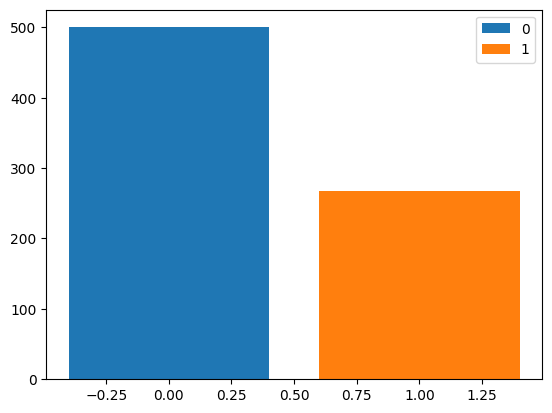

In [22]:
# 시각화 진행

plt.bar(0, len(df[df['Outcome'] == 0]), label='0')
plt.bar(1, len(df[df['Outcome'] == 1]), label='1')

print ("0 : ", len(df[df['Outcome'] == 0]))
print ("1 : ", len(df[df['Outcome'] == 1]))

plt.legend()
plt.show()

위를 확인해보면, Outcome 열의 0과 1의 도수가 불균형하여 추후 분류 시 편향이 발생할 가능성이 높다. 따라서 아래와 같은 방안을 생각해볼 수 있다.

- 오버 샘플링 (oversampling)
    - 소수 클래스인 1의 데이터 갯수를 늘려 불균형을 해소한다.
    - 데이터 손실이 없는 것이 장점이지만, 학습 시간이 증가할 수 있다.
        - 현재 데이터 수가 그리 많지 않기 때문에 괜찮을 듯 하다.
- 언더 샘플링 (undersampling)
    - 다수 클래스인 0의 데이터 갯수를 줄여 불균형을 해소한다.
    - 오버 샘플링과 반대로 작용한다.

하지만 현재 classification의 주제는 당뇨병으로, target층을 일반인으로 데이터 수집 시 당연히 당뇨병 환자가 당뇨병에 걸리지 않은 사람보다 더 적다. 따라서 이에 대한 방안은 철회한 후, 가장 중요한 것을 생각하였을 때, train set과 test set의 split을 어떻게 할 지를 고려하는 것이 맹점이 되겠다. 


**train_test_split 함수에서 stratify 옵션을 사용하는 것이 핵심**이 되겠다. 이 옵션은 학습 데이터셋과 테스트 데이터셋 내에서 목표 변수의 분포를 동일하게 유지하는데, 만약 y 변수가 0과 1로 이루어진 이진 범주형 변수이고, 0의 비율이 25%, 1의 비율이 75%라면, stratify=y를 사용하면 랜덤 분할을 해도 0이 25%, 1이 75%인 비율을 유지할 수 있기 때문에 현재 target 분포에 꼭 필요한 옵션일 것이다.

#### 1-3) seaborn을 통한 상관관계 heatmap 및 전체 histplot 시각화

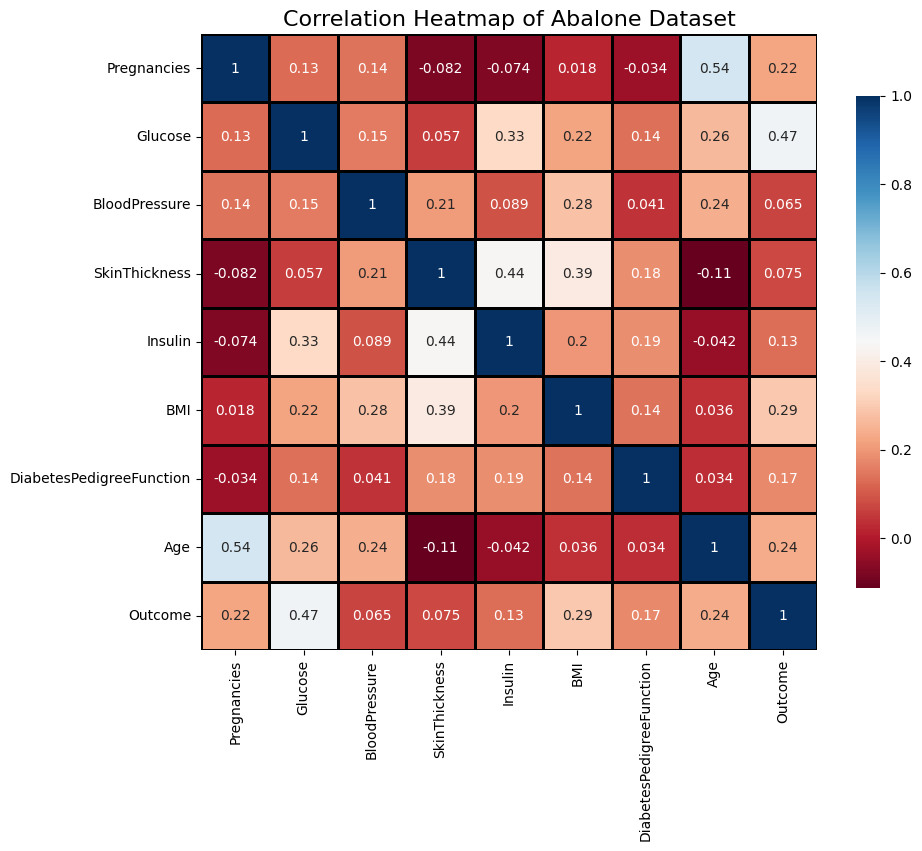

In [23]:
# seaborn을 통하여 heatmap 시각화
# 상관계수 행렬, 각 변수 간의 선형적 관계를 시각적으로 표시

correlation_matrix = df[df.columns].corr() 
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Abalone Dataset', fontsize=16)
plt.show()

위 heatmap는 음수로 갈 수록 음의 상관관계(반비례), 양수로 갈 수록 양의 상관관계(정비례)를 의미한다. 또한 diagonal을 중심으로 각 part가 대칭이다. (symmetric) figure를 보고 주목해야 할 부분은 아래와 같이 분석할 수 있다.

- **높은 상관관계**
     - **Length와 Diameter (0.99)**
        - 매우 높은 양의 상관관계, Length와 Diameter는 거의 일치

    - **Length와 Whole weight (0.93)**, **Diameter와 Whole weight (0.93)**:
        - 길이와 직경, 무게가 매우 높은 상관관계, 이를 통하여 길이랑 직경이 크면 무게도 무겁다는 것을 예측 가능

    - **Whole weight와 Shucked weight (0.97)**, **Whole weight와 Viscera weight (0.97)**:
        - 전복의 전체 무게는 껍질을 벗긴 무게와 내장 무게와 매우 높은 상관관계를 가지므로, 전체 무게가 부분 무게들에 의해 크게 좌우되는 것을 예측 가능

    - **Shucked weight와 Viscera weight (0.93)**:
        - 두 무게가 함께 증가하거나 감소하는 경향 있음

    - **Length와 Shell weight (0.9)**, **Diameter와 Shell weight (0.91)**:
        - 전복의 길이와 직경은 껍질 무게와도 높은 상관관계 보임

- **낮은 상관관계**  
    - **Sex와 다른 변수들**
        - 성별은 다른 연속형 변수들과 음의 상관관계를 가지며, 특히 높이는 -0.42, 껍질 무게는 -0.45로 나타남, 이는 성별이 전복의 다른 물리적 특성과 직접적으로 큰 관련이 없음을 나타냄
       
상관관계가 낮은 Sex 특성을 제거해도 score에 큰 영향이 가지 않을 것이니 추후에 전처리 시 제거한다. 

위 heatmap는 음수로 갈 수록 음의 상관관계(반비례), 양수로 갈 수록 양의 상관관계(정비례)를 의미한다. 또한 diagonal을 중심으로 각 part가 대칭이다. (symmetric) figure를 보고 주목해야 할 부분은 아래와 같이 분석할 수 있다.


- **높은 상관관계**
    - **Age와 Pregnancies (0.54)**
        - Age와 Pregnancies는 높은 양의 상관관계를 가지며, 나이가 많을수록 임신 횟수가 많아지는 경향이 있음
    - **Glucose와 Outcome (0.47)**
        - Glucose와 Outcome은 높은 양의 상관관계를 가지며, 포도당 수치가 높을수록 당뇨병일 가능성이 높음
    - **BMI와 Outcome (0.29)**
        - BMI와 Outcome은 양의 상관관계를 가지며, 체질량 지수가 높을수록 당뇨병일 가능성이 높음
    - **Age와 Outcome (0.24)**
        - Age와 Outcome은 양의 상관관계를 가지며, 나이가 많을수록 당뇨병일 가능성이 높음

- **낮은 상관관계**
    - **SkinThickness와 Pregnancies (-0.082)**
        - SkinThickness와 Pregnancies는 음의 상관관계를 가지며, 삼두근 피부 두께와 임신 횟수는 크게 관련이 없음
    - **Insulin과 Pregnancies (-0.074)**
        - Insulin과 Pregnancies는 음의 상관관계를 가지며, 인슐린 수치와 임신 횟수는 크게 관련이 없음
    - **DiabetesPedigreeFunction과 Pregnancies (-0.034)**
        - DiabetesPedigreeFunction과 Pregnancies는 음의 상관관계를 가지며, 당뇨병 혈통 함수와 임신 횟수는 크게 관련이 없음

classification을 진행한 후, 번외로 아래와 같이 feature를 선택 및 제거하여 KNN, logistic regression 모델에 fit한 후 이전 score와 비교하는 작업을 진행하려고 한다.

- **선택할 Feature**
    - **Glucose**
        - Outcome과 높은 상관관계를 가지므로, 당뇨병 예측에 중요한 변수
    - **BMI**
        - Outcome과 양의 상관관계를 가지며, 체질량 지수가 당뇨병 예측에 중요함
    - **Age**
        - Outcome과 양의 상관관계를 가지며, 나이가 당뇨병 예측에 중요한 역할을 함
    - **Pregnancies**
        - Age와 높은 상관관계를 가지며, 나이와 임신 횟수가 당뇨병 예측에 중요한 변수일 수 있음

- **제거할 Feature**
    - **SkinThickness**
        - 대부분의 변수들과 낮은 상관관계를 가지므로, 당뇨병 예측에 큰 영향을 미치지 않음
    - **DiabetesPedigreeFunction**
        - 대부분의 변수들과 낮은 상관관계를 가지므로, 당뇨병 예측에 큰 영향을 미치지 않음


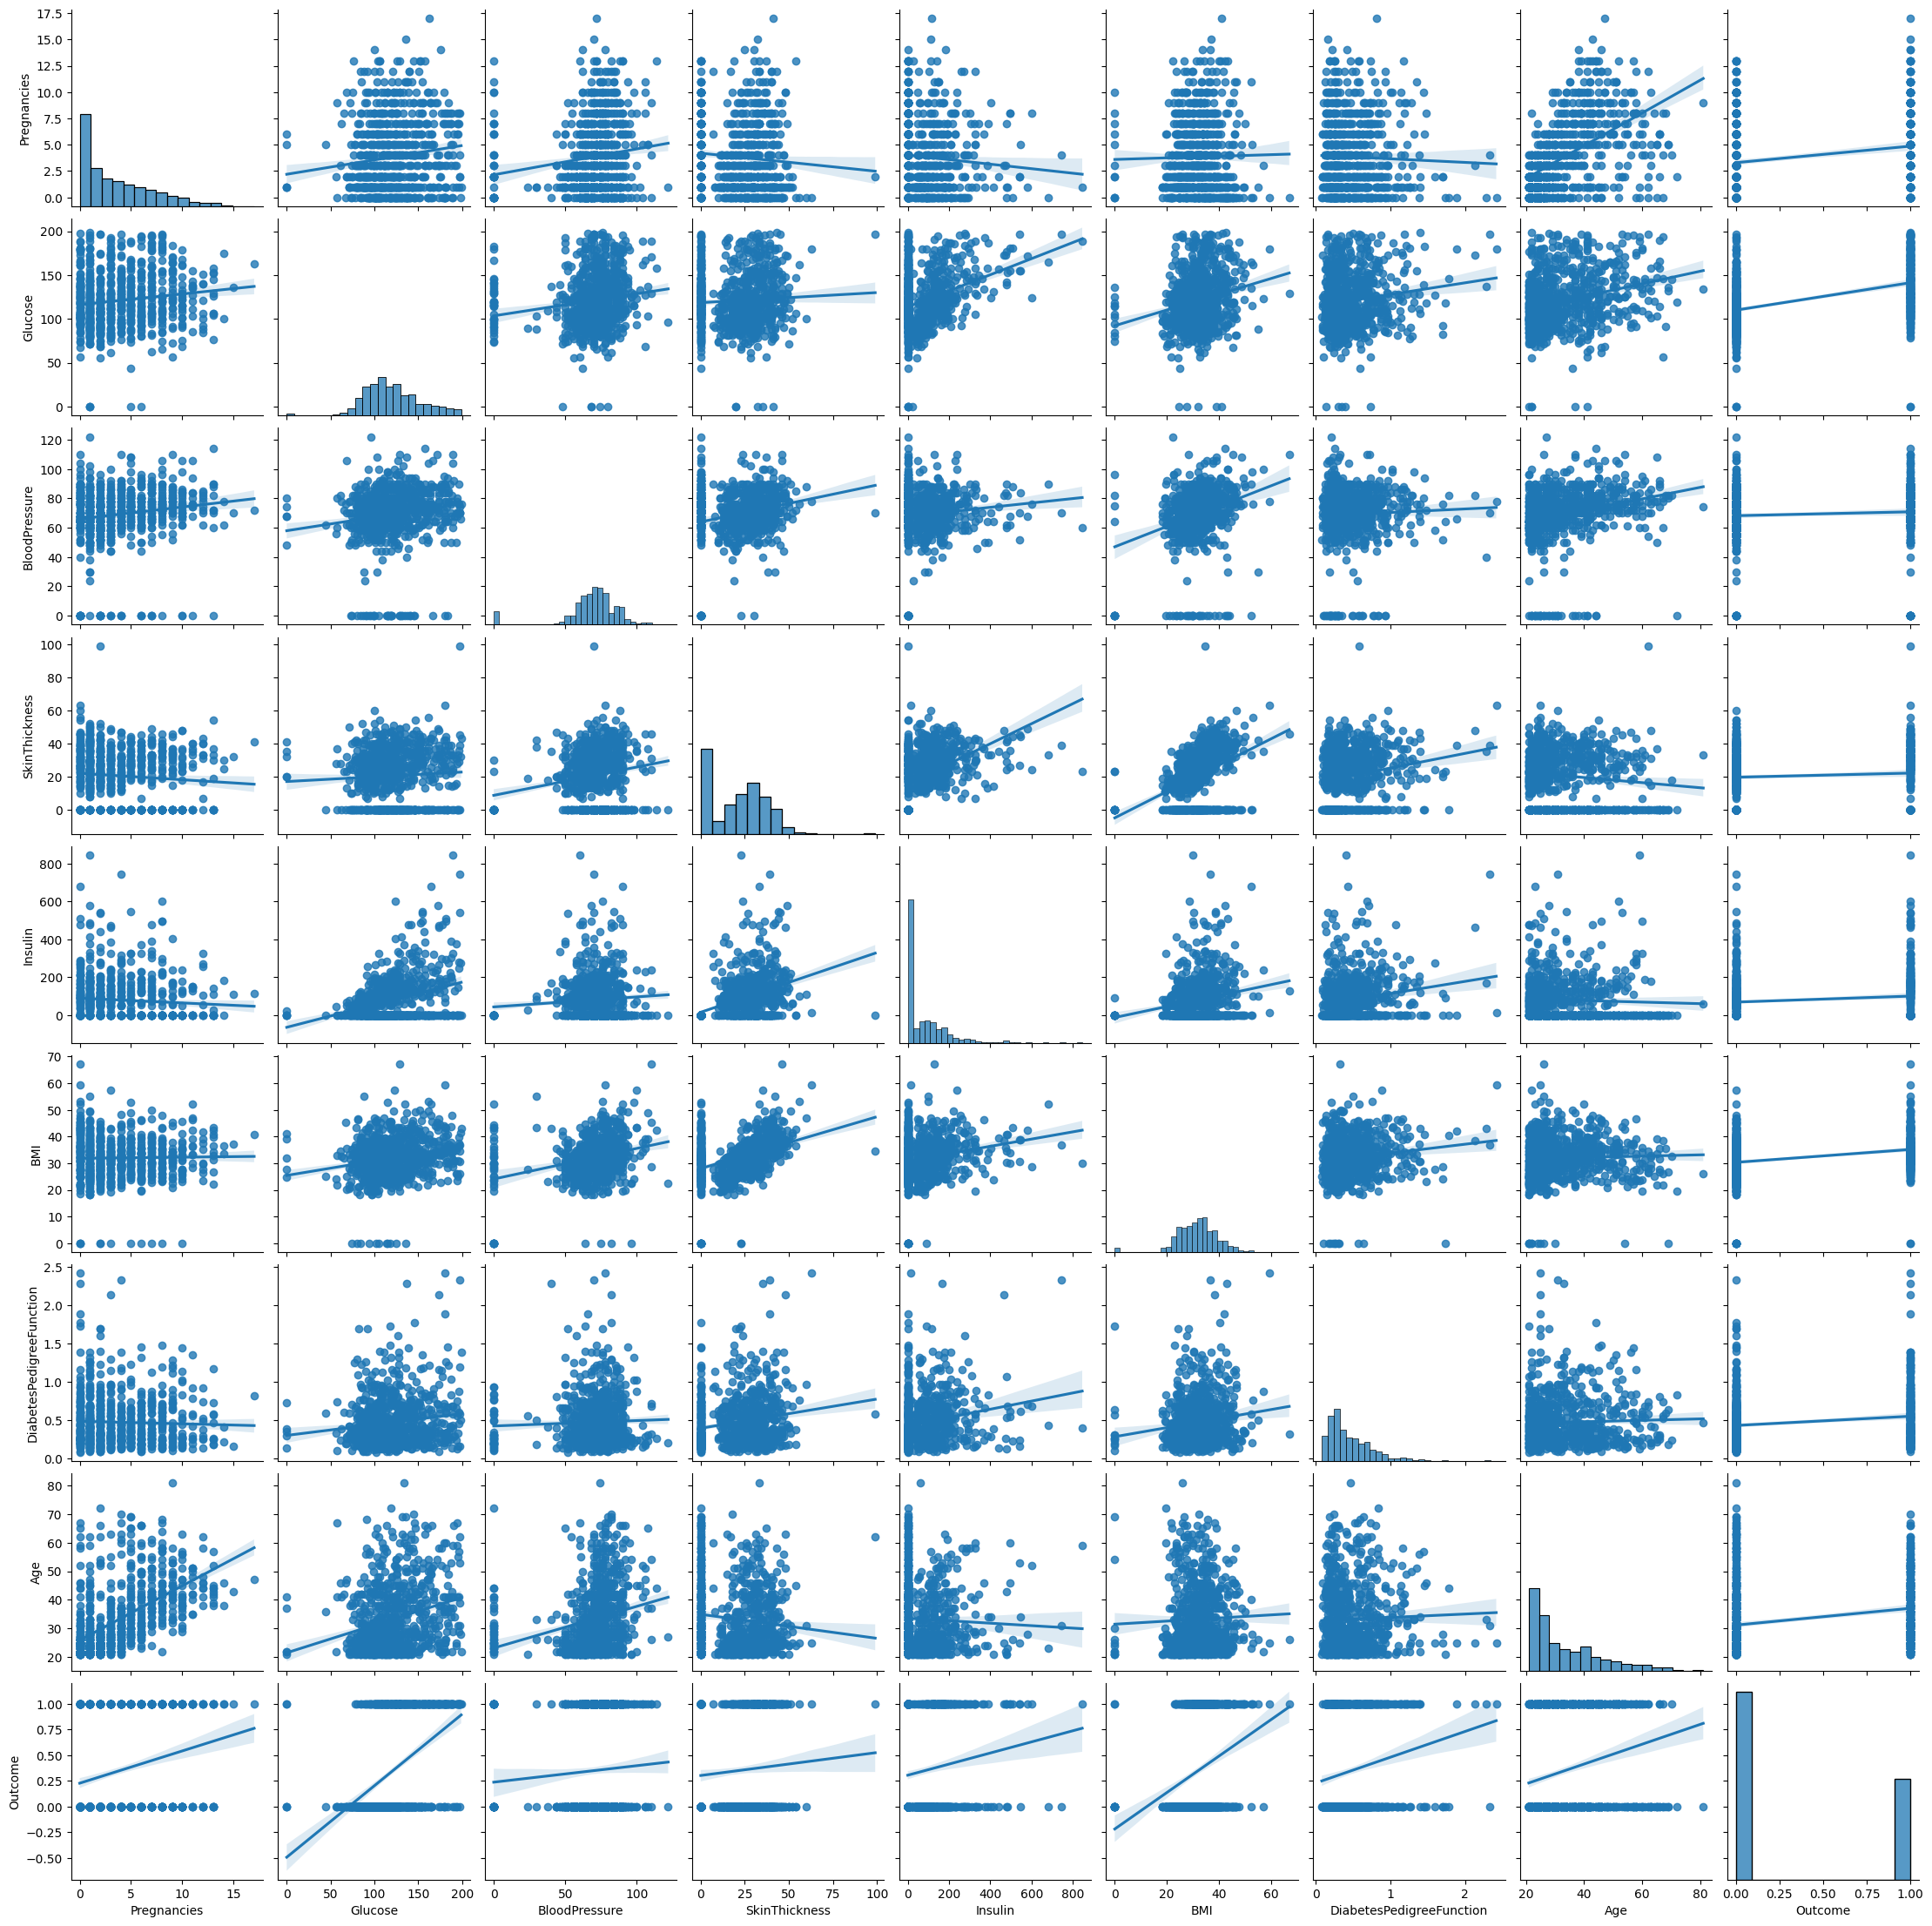

In [24]:
# seaborn을 통하여 pairplot 시각화
# 현재 데이터프레임의 모든 열 쌍에 대한 산점도와 히스토그램을 시각화한다

sns.pairplot(df[df.columns], kind="reg") 
plt.show()

------

#### 1-4) 각 attribute에 대한 box plot 시각화



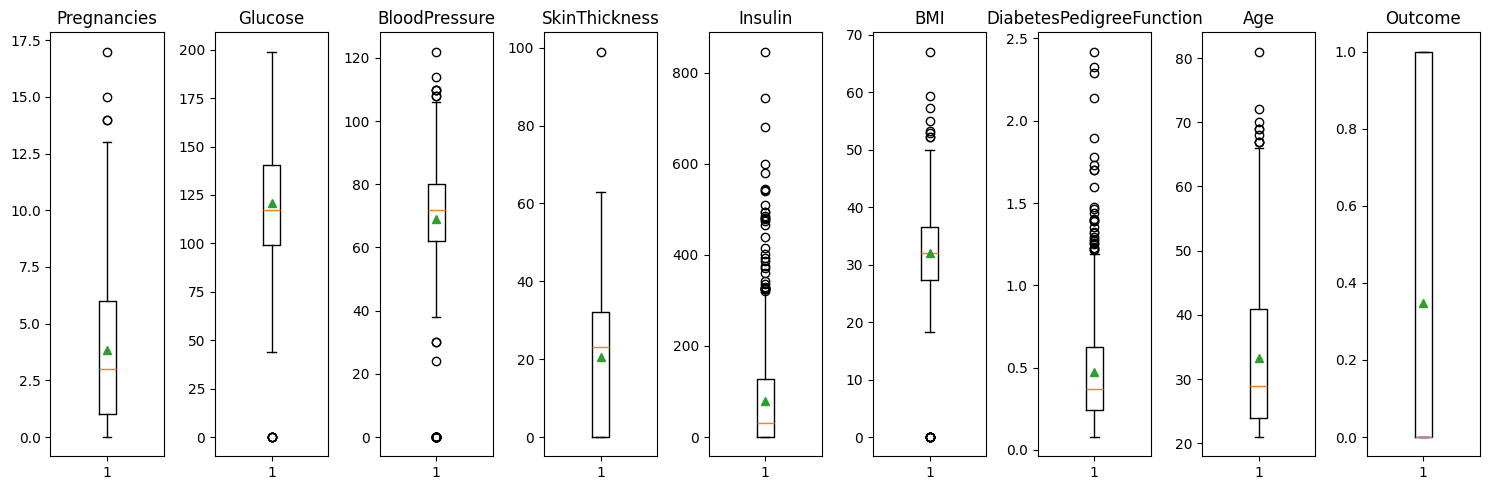

In [26]:
# box plot 그려 데이터 분포 확인

# subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5))

# 각 변수에 대한 boxplot 그리기
for i, var in enumerate(df.columns) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

-----

------

### 2. 데이터 전처리

1에서 분석한 바를 토대로 전처리를 진행한다.
- **전처리**
    - 결측치는 그 feature (열)의 평균으로 fill
    - Z-score normalization 진행 

#### 2-1) 결측치 확인 및 fill 

In [27]:
# 결측치 확인

for feature in df.columns :
    print (f'{feature}열의 결측치 존재 여부 : ', df[feature].isnull())
    print ('\n--------------\n')

print ("데이터의 총 결측치 수 : ", df.isnull().sum())

Pregnancies열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: Pregnancies, Length: 768, dtype: bool

--------------

Glucose열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: Glucose, Length: 768, dtype: bool

--------------

BloodPressure열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: BloodPressure, Length: 768, dtype: bool

--------------

SkinThickness열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: SkinThickness, Length: 768, dtype: bool

--------------

Insulin열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4

위를 보면, 본 데이터에 결측치가 **전혀** 존재하지 않고 있다. 따라서 결측치에 따른 전처리를 진행하지 않아도 된다.

#### 2-2) 정규화 (normalization) - Z-score normalization

- 각 feature의 scale이 서로 달라, SVM, logistic regression 전에 StandardScaler를 통한 스케일링이 필요
- 따라서 StandardScaler를 통한 Z-score normalization을 수행

In [32]:
# input과 target으로 df를 split

diabetes_input = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'BMI', 'DiabetesPedigreeFunction', 'Age']].to_numpy() 
diabetes_target = df['Outcome'].to_numpy()

In [33]:
# X_train, y_train, X_test, y_test으로 train set, test set 각각 8:2로 split
# stratify 옵션을 적용하여 편향 방지

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(diabetes_input, diabetes_target, 
                                                   stratify=diabetes_target, 
                                                    test_size=0.2)

In [34]:
# StandardScaler을 통한 정규화 진행

from sklearn.preprocessing import StandardScaler
ss_transformer = StandardScaler()

ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)

In [38]:
# 번외 : 추후 KNN, logistic regression 시에 사용할 data (feature selection)
# 사용할 feature : Glucose, BMI, Age, Pregnancies

diabetes_input_fs = df[['Glucose', 'BMI', 'Age', 'Pregnancies']].to_numpy() 

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(diabetes_input_fs, diabetes_target, 
                                                   stratify=diabetes_target, 
                                                    test_size=0.2)

ss_transformer = StandardScaler()

ss_transformer.fit(X_train_fs)

X_train_fs_scaled = ss_transformer.transform(X_train_fs)
X_test_fs_scaled = ss_transformer.transform(X_test_fs)

-------

### 3. 각종 모델을 적용하여 classification
- KNN, logistic regression, K-means, decision tree, random forest, SVM 사용하여 classification
- 순서는 KNN, logistic regression, decision tree, random forest, SVM, K-means

#### 3-1) KNN
- n_neighbors을 3부터 450까지 바꾸어 가면서 학습하여 최적의 하이퍼파라미터를 도출 (overfitting, underfitting을 막기 위함)

In [35]:
# KNN을 활용한 모델 fit 및 train score, test score 출력
# 이때, n_neighbors 하이퍼파라미터를 조정해나가면서, 점수를 get

from sklearn.neighbors import KNeighborsClassifier

score_list = [] # [n_neighbors, [train score, test score]]

# n_neighbors를 3부터 450까지 진행 -> 데이터의 절반 (900/2 = 450)까지 값을 테스트하여 최적의 값 찾기

for num in range (3, 451) :
    knn = KNeighborsClassifier(n_neighbors=num)
    knn.fit (X_train_scaled, y_train)
    
    current_score = [num, [knn.score(X_train_scaled, y_train),
                             knn.score(X_test_scaled, y_test)]]
    score_list.append (current_score)
    print (f'n_neighbors : {num} | train score : {current_score[1][0]}, test score : {current_score[1][1]}')

n_neighbors : 3 | train score : 0.8306188925081434, test score : 0.7467532467532467
n_neighbors : 4 | train score : 0.8045602605863192, test score : 0.7272727272727273
n_neighbors : 5 | train score : 0.8257328990228013, test score : 0.7532467532467533
n_neighbors : 6 | train score : 0.7899022801302932, test score : 0.7337662337662337
n_neighbors : 7 | train score : 0.7947882736156352, test score : 0.7207792207792207
n_neighbors : 8 | train score : 0.7915309446254072, test score : 0.7532467532467533
n_neighbors : 9 | train score : 0.7833876221498371, test score : 0.7337662337662337
n_neighbors : 10 | train score : 0.7719869706840391, test score : 0.7337662337662337
n_neighbors : 11 | train score : 0.7752442996742671, test score : 0.7272727272727273
n_neighbors : 12 | train score : 0.7654723127035831, test score : 0.7142857142857143
n_neighbors : 13 | train score : 0.762214983713355, test score : 0.7207792207792207
n_neighbors : 14 | train score : 0.7719869706840391, test score : 0.70779

n_neighbors : 101 | train score : 0.744299674267101, test score : 0.7272727272727273
n_neighbors : 102 | train score : 0.744299674267101, test score : 0.7272727272727273
n_neighbors : 103 | train score : 0.745928338762215, test score : 0.7272727272727273
n_neighbors : 104 | train score : 0.744299674267101, test score : 0.7207792207792207
n_neighbors : 105 | train score : 0.744299674267101, test score : 0.7207792207792207
n_neighbors : 106 | train score : 0.747557003257329, test score : 0.7142857142857143
n_neighbors : 107 | train score : 0.747557003257329, test score : 0.7207792207792207
n_neighbors : 108 | train score : 0.744299674267101, test score : 0.7207792207792207
n_neighbors : 109 | train score : 0.745928338762215, test score : 0.7207792207792207
n_neighbors : 110 | train score : 0.742671009771987, test score : 0.7077922077922078
n_neighbors : 111 | train score : 0.741042345276873, test score : 0.7142857142857143
n_neighbors : 112 | train score : 0.745928338762215, test score :

n_neighbors : 198 | train score : 0.7084690553745928, test score : 0.6363636363636364
n_neighbors : 199 | train score : 0.7117263843648208, test score : 0.6428571428571429
n_neighbors : 200 | train score : 0.7084690553745928, test score : 0.6428571428571429
n_neighbors : 201 | train score : 0.7100977198697068, test score : 0.6428571428571429
n_neighbors : 202 | train score : 0.7084690553745928, test score : 0.6363636363636364
n_neighbors : 203 | train score : 0.7084690553745928, test score : 0.6363636363636364
n_neighbors : 204 | train score : 0.7068403908794788, test score : 0.6363636363636364
n_neighbors : 205 | train score : 0.7100977198697068, test score : 0.6363636363636364
n_neighbors : 206 | train score : 0.7084690553745928, test score : 0.6363636363636364
n_neighbors : 207 | train score : 0.7084690553745928, test score : 0.6428571428571429
n_neighbors : 208 | train score : 0.7084690553745928, test score : 0.6428571428571429
n_neighbors : 209 | train score : 0.7100977198697068, 

n_neighbors : 294 | train score : 0.6644951140065146, test score : 0.6558441558441559
n_neighbors : 295 | train score : 0.6644951140065146, test score : 0.6558441558441559
n_neighbors : 296 | train score : 0.6612377850162866, test score : 0.6558441558441559
n_neighbors : 297 | train score : 0.6612377850162866, test score : 0.6558441558441559
n_neighbors : 298 | train score : 0.6612377850162866, test score : 0.6558441558441559
n_neighbors : 299 | train score : 0.6628664495114006, test score : 0.6558441558441559
n_neighbors : 300 | train score : 0.6612377850162866, test score : 0.6558441558441559
n_neighbors : 301 | train score : 0.6628664495114006, test score : 0.6558441558441559
n_neighbors : 302 | train score : 0.6628664495114006, test score : 0.6558441558441559
n_neighbors : 303 | train score : 0.6628664495114006, test score : 0.6558441558441559
n_neighbors : 304 | train score : 0.6612377850162866, test score : 0.6558441558441559
n_neighbors : 305 | train score : 0.6628664495114006, 

n_neighbors : 394 | train score : 0.6514657980456026, test score : 0.6493506493506493
n_neighbors : 395 | train score : 0.6514657980456026, test score : 0.6493506493506493
n_neighbors : 396 | train score : 0.6514657980456026, test score : 0.6493506493506493
n_neighbors : 397 | train score : 0.6514657980456026, test score : 0.6493506493506493
n_neighbors : 398 | train score : 0.6514657980456026, test score : 0.6493506493506493
n_neighbors : 399 | train score : 0.6514657980456026, test score : 0.6493506493506493
n_neighbors : 400 | train score : 0.6514657980456026, test score : 0.6493506493506493
n_neighbors : 401 | train score : 0.6514657980456026, test score : 0.6493506493506493
n_neighbors : 402 | train score : 0.6514657980456026, test score : 0.6493506493506493
n_neighbors : 403 | train score : 0.6514657980456026, test score : 0.6493506493506493
n_neighbors : 404 | train score : 0.6514657980456026, test score : 0.6493506493506493
n_neighbors : 405 | train score : 0.6514657980456026, 

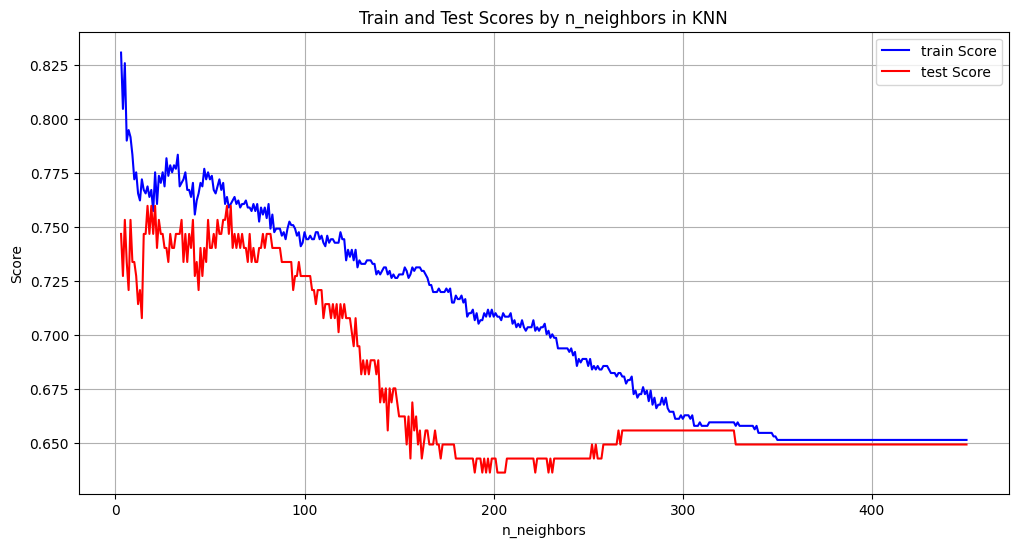

In [39]:
# 위 결과를 시각화화여 가장 적합한 n_neighbors 파라미터를 찾는다

n_neighbors_values = [score[0] for score in score_list] # n_neighbors
train_scores = [score[1][0] for score in score_list] # train score
test_scores = [score[1][1] for score in score_list] # test score

plt.figure(figsize=(12, 6))
plt.plot(n_neighbors_values, train_scores, label='train Score', color='blue')
plt.plot(n_neighbors_values, test_scores, label='test Score', color='red')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.title('Train and Test Scores by n_neighbors in KNN')
plt.legend()
plt.grid(True)
plt.show()

위 figure을 보고 아래와 같이 분석 가능하다.

- 1) 현재 train score은 n_neighbors 하이퍼파라미터가 증가함에 따라 감소하는 우하향의 추세를 보인다.
- 2) test score은 train score 추세선과 비슷한 양상으로 우하향한다.

 train score와 test score의 차이가 가장 적으면서, 그 점에 해당되는 n_neighbors 중 train score가 가장 높은 n_neighbors 하이퍼파라미터를 택하여 다시 학습을 진행한다.

In [42]:
# train score >= test score이면서 차이가 0.05 미만인 n_neighbors 찾기

optimal_point = [[compo[0], compo[1][0], abs(compo[1][0] - compo[1][1])] for compo in score_list if compo[1][0] >= compo[1][1]]

# 오차가 가장 적으면서, train score에 내림차순되게 정렬
optimal_point.sort (key = lambda x : (x[2], -x[1]))
print (optimal_point)
print ('train score >= test score이면서 차이가 가장 작고, n_neighbors 중 가장 train score가 높은 n_neighbors : ',
      optimal_point[0][0])

[[61, 0.760586319218241, 0.0008460594779813313], [350, 0.6514657980456026, 0.0021151486949532172], [351, 0.6514657980456026, 0.0021151486949532172], [352, 0.6514657980456026, 0.0021151486949532172], [353, 0.6514657980456026, 0.0021151486949532172], [354, 0.6514657980456026, 0.0021151486949532172], [355, 0.6514657980456026, 0.0021151486949532172], [356, 0.6514657980456026, 0.0021151486949532172], [357, 0.6514657980456026, 0.0021151486949532172], [358, 0.6514657980456026, 0.0021151486949532172], [359, 0.6514657980456026, 0.0021151486949532172], [360, 0.6514657980456026, 0.0021151486949532172], [361, 0.6514657980456026, 0.0021151486949532172], [362, 0.6514657980456026, 0.0021151486949532172], [363, 0.6514657980456026, 0.0021151486949532172], [364, 0.6514657980456026, 0.0021151486949532172], [365, 0.6514657980456026, 0.0021151486949532172], [366, 0.6514657980456026, 0.0021151486949532172], [367, 0.6514657980456026, 0.0021151486949532172], [368, 0.6514657980456026, 0.0021151486949532172], [

In [41]:
# n_neighbors=144으로 fit, score

knn = KNeighborsClassifier(n_neighbors=144)
knn.fit (X_train_scaled, y_train)
print (f"train score, test score : {knn.score(X_train_scaled, y_train), knn.score(X_test_scaled, y_test)}")

train score, test score : (0.7280130293159609, 0.6558441558441559)


train score가 test score가 차이가 나는 것을 보아 본 model은 overfitting되었다는 것을 알 수 있다. 따라서 위에서 **feature selection을 진행한 dataset을 이용하여 위 과정을 그대로 진행**한다. (시각화 및 출력 제외) score의 차이가 어떻게 나는지를 확인하자.

In [44]:
score_list = [] # [n_neighbors, [train score, test score]]

for num in range (3, 451) :
    knn = KNeighborsClassifier(n_neighbors=num)
    knn.fit (X_train_fs_scaled, y_train) # fs 추가
    
    current_score = [num, [knn.score(X_train_fs_scaled, y_train),
                             knn.score(X_test_fs_scaled, y_test)]]
    score_list.append (current_score)

optimal_point = [[compo[0], compo[1][0], abs(compo[1][0] - compo[1][1])] for compo in score_list if compo[1][0] >= compo[1][1]]

optimal_point.sort (key = lambda x : (x[2], -x[1]))
print ('train score >= test score이면서 차이가 가장 작고, n_neighbors 중 가장 train score가 높은 n_neighbors : ',
      optimal_point[0][0])

knn = KNeighborsClassifier(n_neighbors=optimal_point[0][0])
knn.fit (X_train_scaled, y_train)
print (f"train score, test score : {knn.score(X_train_scaled, y_train), knn.score(X_test_scaled, y_test)}")

train score >= test score이면서 차이가 가장 작고, n_neighbors 중 가장 train score가 높은 n_neighbors :  29
train score, test score : (0.7785016286644951, 0.7467532467532467)


**놀랍게도, feature selection을 통하여 overfitting을 막았다!** 조금 아쉬운 건, 전체적으로 70점대라는 낮은 결정계수를 보여, 추후에 특성공학 측면에서 PolynormialFeatures와 같은 메소드를 도입하여 특성을 추가하여 전체적인 점수를 높일 수 있다고 생각한다. (이 내용은 모든 모델의 classification이 완료된 후, 번외로 다루어보자.)

#### 3-2) logistic regression

- logistic regression 모델을 사용하여 다중 분류를 진행한다.
- softmax 함수를 사용하여 feature 수만큼의 z값을 확률로 변환한다.
    - 직접 z값을 구하여 진행할 수 있으나, predict_proba 메소드를 사용하여 진행하도록 한다.
- hyperparameter tuning
    - grid search는 아래와 같이 정의한다.
        - C : log scale로 10^-10 ~ 10^10 사이 20개의 수
        - max_iter : 1000, 2000, 3000, 4000, 5000
        - n_jobs : -1 (CPU 코어 최대 사용)
    - random search는 아래와 같이 정의한다.
        - C : log scale로 10^-10 ~ 10^10 사이 20개의 수
        - max_iter : 1000, 2000, 3000, 4000, 5000
        - n_jobs : -1 (CPU 코어 최대 사용)

In [ ]:
# logistic regression 모델 fit 및 train score, test score 출력
# 이때, C와 max_iter 최적의 하이퍼파라미터를 찾기 위해 grid search 기법 사용

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 하이퍼파라미터 그리드 정의
param_grid = {
    'C': np.logspace(-10, 10, 20),
    'max_iter': [100, 200, 300, 400, 500]
}

# Logistic Regression 모델 정의
lr = LogisticRegression()

# Grid Search 설정
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fit
grid_search.fit(X_train_scaled, y_train)

# 최적의 하이퍼파라미터 출력 및 score 출력
print(f'최적의 hyperparameter : {grid_search.best_params_}')
print(f'cross-validation score : {grid_search.best_score_}')
